In [ ]:
#default_exp hotmax

# Hotmax spectra

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

A MA-XRF spectral image data cube contains typically a million spectra or so. Far too many to analyze them individually! Furthermore, most of these spectra have low signals and are rather noisy. A common approach to overcome computational problems is to base a further data analysis solely on the max spectrum. Such an approach is used e.g. by *DataMunger* (Mathias Alfeld **need link here**). As discussed above, the max spectrum essentially is an envelope that provides a highly informative summary of all spectra. It is important to understand that different peaks in the max spectrum envelope can originate from different pixel positions in the spectral image. This complicates attribution of the peaks directly from the max spectrum. 

### Locating the hotmax pixels and spectra 

A more sophisticated approach is to locate for each peak in the max spectrum envelope which specific pixel spectrum is responsible for that specific peak. Loosely speaking, which pixels in the spectral image data cube are 'hotmax'? Another way to explain this is to find the specific 'hotmax' spectra that touches the corresponding max spectrum peaks.    

A requisite step in the data analysis now is to find the hotmax pixels and spectra. Locating them takes a few minutes, and should be done once using the `get_hotmax_spectra()` function. The user is prompted to inspect and save the result in the datastack file.   

<IPython.core.display.Javascript object>


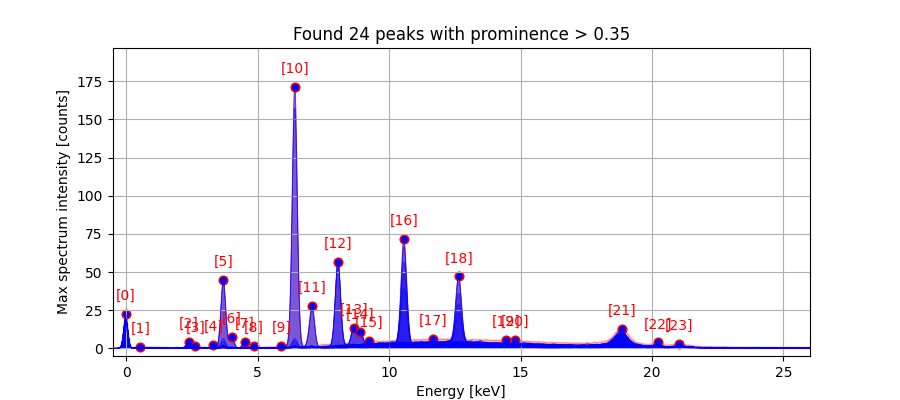

Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed | 47.8s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 
Write hotmax spectra and pixels to datastack file [y/n]? n


In [ ]:
from maxrf4u import get_hotmax_spectra, DataStack

hotmax_pixels, hotmax_spectra = get_hotmax_spectra('RP-T-1898-A-3689.datastack')

In further analysis our stored hotmax pixel indexes and hotmax spectra can now be accessed using the `DataStack.read_hotmax_spectra()` method. Let's inspect the shapes of these arrays first. 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
hotmax_pixels, hotmax_spectra = ds.read_hotmax_spectra()

n_pixels, n_dims = hotmax_pixels.shape
n_spectra, n_channels = hotmax_spectra.shape 

print(f'The array of hotmax pixels contains {n_pixels} pixels. ')
print(f'Each pixel consists of {n_dims} indexes.\n')
print(f'There are {n_spectra} hotmax spectra.')
print(f'Each spectrum contains {n_channels} intensity values.')

The array of hotmax pixels contains 24 pixels. 
Each pixel consists of 3 indexes.

There are 24 hotmax spectra.
Each spectrum contains 4096 intensity values.


Now let's pick one of the 24 hotmax spectra and take a closer look by plotting with `matplotlib`. It is interesting to compare this spectrum with the max spectrum envelope to see which (hotmax) peak corresponds to both spectra. 

<IPython.core.display.Javascript object>


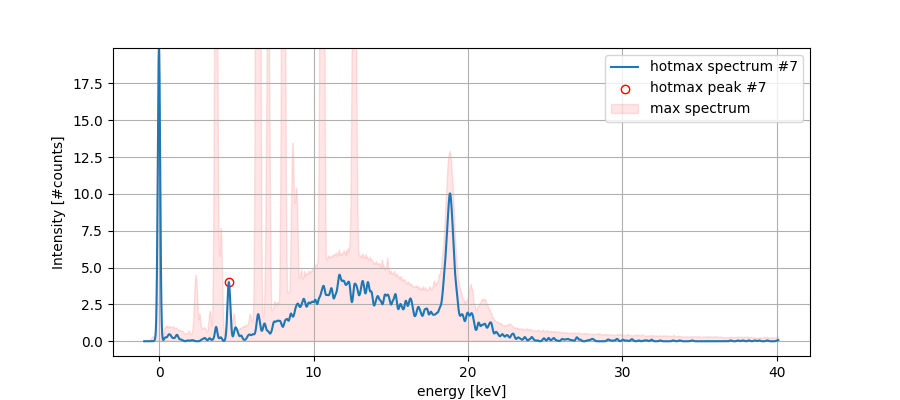

In [ ]:
import matplotlib.pyplot as plt 

ds = DataStack('RP-T-1898-A-3689.datastack')

hotmax_pixels, hotmax_spectra = ds.read_hotmax_spectra()
x_keVs = ds.read_energies()
y_max = ds.read_maxspectrum()

n = 7 

y_hot = hotmax_spectra[n]
i = hotmax_pixels[n, 2] # channel index of hotmax peak 

fig, ax = plt.subplots(figsize=[9, 4])

ax.plot(x_keVs, y_hot, label=f'hotmax spectrum #{n}')
ax.scatter(x_keVs[i], y_hot[i], edgecolor='r', facecolor='w', label=f'hotmax peak #{7}')
ax.fill_between(x_keVs, y_max, color='r', alpha=0.1, label='max spectrum')
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Intensity [#counts]')
ax.set_ylim(-1, y_hot.max())
ax.grid()
ax.legend();

The measured spectrum consists of a a slowly varying baseline, the so-called the Compton ridge, with peaks added on top. Some of these peaks are caused by x-ray fluorescence of specific chemical elements. Other peaks are just noise. 

The difficulty with these kind of spectra is that the noise level varies with the signal according to Poisson statistics. The variance of noise is linearly proportional to the signal level. For this reason, we observe more noise on top of the Compton ridge. 

In order to distinguish significant peaks from noise it is possible to estimate a baseline with a noise envelope for the hotmax spectra with the `get_hotmax_basenoise()`function. The algorithm used in estimating the baseline function is the rolling ball filter. In accordance with Poisson statistics, the noise level is estimated as a square root function of the baseline level. 

In [ ]:
from maxrf4u import get_hotmax_basenoise

hotmax_baselines, hotmax_noiselines = get_hotmax_basenoise('RP-T-1898-A-3689.datastack')

Write hotmax baselines and noiselines to datastack file [y/n]? y

Saved hotmax noise data to: RP-T-1898-A-3689.datastack


## Module `maxrf4u.hotmax.py`

In [ ]:
#export 

import maxrf4u 
import scipy.signal as ssg 
import numpy as np 
import time 
import matplotlib.pyplot as plt 
from dask.diagnostics import ProgressBar 
import scipy.ndimage.morphology as morph 
import scipy.interpolate as sip 


def get_hotmax_spectra(datastack_file, prominence=0.35): 
    '''Collect hotmax pixels and corresponding spectra from *datastack_file*. 
    
    Ask user confirmation for saving result to datastack file. 
    '''
   
    # read max spectrum 
    ds = maxrf4u.DataStack(datastack_file)
    x_keVs = ds.read_energies()
    y_max = ds.read_maxspectrum()

    # locate max spectrum peaks in max spectrum 
    peak_indices, _ = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x = x_keVs[peak_indices]
    peaks_y = y_max[peak_indices]
    
    # plot max spectrum with peaks 
    
    plt.close('all')
    
    plt.ion() # important for updating plots with fig.canvas.draw() 
    
    fig, ax = plt.subplots(figsize=[9, 4])

    fig.canvas.draw()   
    ax.fill_between(x_keVs, y_max, color='r', alpha=0.3)
    ax.scatter(peaks_x, peaks_y, facecolor='w', edgecolor='r')  
    ax.set_xlim(peaks_x[0] - 0.5, peaks_x[-1] + 5) 
    ax.set_ylim(-5, 1.15 * np.max(peaks_y))
    
    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
    

    for i, peak_xy in enumerate(zip(peaks_x, peaks_y)): 
        ax.annotate(f'[{i}]', peak_xy, xytext=[0, 10], color='r', 
                        textcoords='offset points', ha='center')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel('Max spectrum intensity [counts]')
    ax.set_title(f'Found {len(peak_indices)} peaks with prominence > {prominence}')
    ax.grid()

    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
 
    
    # read corresponding channel maps for all max peak indices 
    print('Step 1/3: Reading hot max channel maps...')
    with ProgressBar(): 
        channel_maps = ds.maxrf_cube[:,:,peak_indices].compute() 

    channel_maps = channel_maps.transpose([2, 0, 1])

    # locate hot max pixels in channel maps 
    print('Step 2/3: Locating hot max pixels...')
    hot_pixels = []
    for k, c_map in enumerate(channel_maps): 
        hot_i, hot_j = np.argwhere(c_map == peaks_y[k]).flatten()
        hot_pixels.append([hot_i, hot_j, peak_indices[k]])

    hot_pixels = np.array(hot_pixels)    

    # read spectrum for each hot max pixel  
    hot_spectra = [] 
    for n, [i, j, _] in enumerate(hot_pixels):
        print(f'Step 3/3: Reading hot max spectrum {n}/{len(hot_pixels) - 1}...', end='\r')
        spectrum = ds.maxrf_cube[i,j,:].compute()
        hot_spectra.append(spectrum)
        
        ax.plot(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.5) 
        ax.fill_between(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.3) 
        ax.scatter(peaks_x[n], peaks_y[n], facecolor='b', edgecolor='r') 

        # force updating plot 
        plt.pause(0.2) 
        fig.canvas.draw()
        fig.canvas.flush_events()
        
    print(f'Step 3/3: Ready with reading hot max spectra. ')

    hot_spectra = np.array(hot_spectra)  
    
    # user input           
    write = input('Write hotmax spectra and pixels to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(hot_spectra, maxrf4u.HOTMAX_SPECTRA, ds.datastack_file)
        maxrf4u.append(hot_pixels, maxrf4u.HOTMAX_PIXELS, ds.datastack_file) 

        print(f'\nSaved hotmax data to: {ds.datastack_file}')
        
    # force updating plot 
    plt.pause(0.3) 
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    return hot_pixels, hot_spectra 
    

    

def _baseline(x_keVs, spectrum, radius=200, return_indices=False): 
    '''Calculate rolling ball baseline for *spectrum*.  
    
    Uses Euclidian distance map to select only the lowest surges that touch the rolling ball.'''

    spectrum_norm = spectrum / spectrum.max()
    
    w = len(spectrum) 
    h = w // 2

    # initialize ramp with normalized spectrum in top half  
    ramp = np.ones([h, w]) * np.linspace(1, -1, h)[:, None]
    
    # create boolean mask from spectrum 
    spectrum_mask = ramp < spectrum_norm 
    
    # create distance map for spectrum mask. 
    dist_map, index_images = morph.distance_transform_edt(spectrum_mask, return_indices=True)

    # we only need the second (x-axis) channel index image
    _, index_img = index_images 

    # roll the ball 
    ball_mask = dist_map < radius 
    ball_profile = ball_mask.sum(axis=0) 

    # get touching surges indices 
    lowest_indices = list(set(index_img[ball_profile, range(w)]))
    
    # create linear interpolation between the selected lowest surges (valleys)
    interpolation = sip.interp1d(x_keVs[lowest_indices], spectrum[lowest_indices], bounds_error=False)
    baseline = interpolation(x_keVs) 
    
    # valley indices 
    if return_indices: 
        return baseline, lowest_indices 
    
    return baseline 

def _noiseline(baseline, alpha=0.6, beta=0.1): 
    '''Estimate Poisson noise line from *baseline*. '''
    
    noiseline = baseline + alpha * np.sqrt(baseline + beta**2)
    
    return noiseline 


def get_hotmax_basenoise(datastack_file, radius=200, alpha=0.6, beta=0.1): 
    '''Utility function to get baselines and noiselines from hotmax spectra in *datastack_file*.  
    
    Use once to compute base noise envelopes. Ask user confirmation for saving result to datastack file. '''
    
    ds = maxrf4u.DataStack(datastack_file)
    
    x_keVs = ds.read_energies()
    hotmax_spectra = ds.read_hotmax_spectra()[1]
        
    baseline_spectra = []  
    noiseline_spectra = []
    
    for i, spectrum in enumerate(hotmax_spectra): 
        
        print(f'Calculating envelope for spectrum {i+1}/{len(hotmax_spectra)}...', end='\r')
        
        baseline, lowest_indices = _baseline(x_keVs, spectrum, radius=radius, return_indices=True)
        baseline_spectra.append(baseline)
        
        noiseline = _noiseline(baseline, alpha=alpha, beta=beta) 
        noiseline_spectra.append(noiseline)
    
    # user input           
    write = input('Write hotmax baselines and noiselines to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(baseline_spectra, maxrf4u.HOTMAX_BASELINES, ds.datastack_file)
        maxrf4u.append(noiseline_spectra, maxrf4u.HOTMAX_BASELINES, ds.datastack_file) 

        print(f'\nSaved hotmax noise data to: {ds.datastack_file}')
    
    return baseline_spectra, noiseline_spectra 



In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
from maxrf4u.hotmax import _baseline

In [ ]:
_baseline()

In [ ]:
baseline_spectra, noiseline_spectra = get_hotmax_noise('RP-T-1898-A-3689.datastack')

Write hotmax baselines and noiselines to datastack file [y/n]? y

Saved hotmax noise envelopes to: RP-T-1898-A-3689.datastack


In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack')

In [ ]:
class HotmaxAtlas(DataStack): 
    
    

True

In [ ]:
ds.read_hotmax_spectra()

(array([[ 546, 1155,   95],
        [ 805,  204,  151],
        [ 951,  409,  335],
        [ 840,   22,  359],
        [ 853,  803,  427],
        [ 793,  908,  465],
        [ 793,  909,  497],
        [1666,  925,  547],
        [ 124,   51,  581],
        [1294,  862,  685],
        [ 657,  327,  736],
        [1425,   32,  802],
        [ 489,  122,  900],
        [ 489,  122,  960],
        [ 489,  122,  984],
        [ 889,  280, 1017],
        [ 891,  216, 1150],
        [ 474,  181, 1261],
        [ 890,  217, 1358],
        [ 883,  636, 1539],
        [ 933,  297, 1573],
        [1520,  412, 1976],
        [1604,  487, 2112],
        [1661,  797, 2192]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.0160986 , 0.0143417 ,
         0.01345091],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.  

In [ ]:
import maxrf4u 
import scipy.signal as ssg 
import numpy as np 


class HotmaxAtlas(): 
    
    def __init__(self, datastack_file, prominence=0.2): 
        
        self.datastack_file = datastack_file 
        
        ds = maxrf4u.DataStack(self.datastack_file)
        
        self.x_keVs = ds.read_energies() 
        self.y_max = ds.read_maxspectrum()
        
        self.hotmax_pixels, self.hotmax_spectra = ds.read_hotmax() 
        self.n_spectra = len(self.hotmax_spectra) 
        
        self.hotspectrum_list = []
        self.baseline_list = []
        self.noiseline_list = []
        self.peak_idxs_list = [] 
        
        for i, y_hot in enumerate(self.hotmax_spectra): 
            
            print(f'Analyzing noise envelope for spectrum {i}/{self.n_spectra - 1}...', end='\r')
            
            # noise envelope 
            baseline = maxrf4u.get_baseline(self.x_keVs, y_hot)
            self.baseline_list.append(baseline)
            
            noiseline = maxrf4u.get_noiseline(baseline)
            self.noiseline_list.append(noiseline)

            # subpeaks (=lines)  
            above_noise = y_hot - noiseline 
            above_noise[y_hot < noiseline] = 0 
            peak_idxs, _ = ssg.find_peaks(above_noise, prominence=prominence) 
            self.peak_idxs_list.append(peak_idxs)  
        
        # collect all lines in single list 
        self.all_peaks = []
        for peak_idxs in self.peak_idxs_list: 
            for i in peak_idxs: 
                self.all_peaks.append(i)

        self.all_peaks_set = np.sort(list(set(self.all_peaks))) 
        
    def plot_spectrum(self, n, ax=None): 
        
        if ax is None: 

            fig, ax = plt.subplots(figsize=[10, 3])

        x_keVs = self.x_keVs 
        y_max = self.y_max
        y_hot = self.hotmax_spectra[n] 
        ci = self.hotmax_pixels[n][2]

        ylim = 1.05 * y_hot.max()

        max_peak_indices = hma.hotmax_pixels[:,2]
        max_peak_keVs = x_keVs[max_peak_indices] 

        baseline = hma.baseline_list[n]
        noiseline = hma.noiseline_list[n] 

        peak_indices = hma.peak_idxs_list[n]

        ax.plot(x_keVs, y_hot, zorder=15, label=f'hotmax spectrum #{n}')
        ax.scatter(x_keVs[ci], y_hot[ci], marker='s', zorder=25, edgecolor='r', 
                   facecolor='w', label=f'hotmax peak #{n}')
        ax.fill_between(x_keVs, y_max, color='r', alpha=0.2, zorder=8, label='max spectrum')

        ax.fill_between(x_keVs, baseline, noiseline, color=[0.5, 0.5, 0.9], zorder=10, alpha=0.4, label='noise envelope')

        ax.scatter(x_keVs[peak_indices], y_hot[peak_indices], edgecolor='b', zorder=20, facecolor='w')

        ax.set_xlabel('energy [keV]')
        ax.set_ylabel('Intensity [#counts]')
        ax.set_ylim(-1, ylim)
        ax.set_xlim(-1, 30)
        ax.vlines(max_peak_keVs, ymin=0, ymax=ylim, color='r', alpha=0.3)
        ax.legend() 
        
        if ax is None: 
            plt.tight_layout()
        
        
 

In [ ]:
def plot_spectra(hotmax_atlas):
    
    self = hotmax_atlas 

    fig, axs = plt.subplots(nrows=self.n_spectra, figsize=[9, 1.7*self.n_spectra], sharex=True)

    for n in range(self.n_spectra): 

        self.plot_spectrum(n, ax=axs[n])

    plt.tight_layout()
    
        
        

In [ ]:
hma = HotmaxAtlas('RP-T-1898-A-3689.datastack', prominence=2) #0.1)

<IPython.core.display.Javascript object>


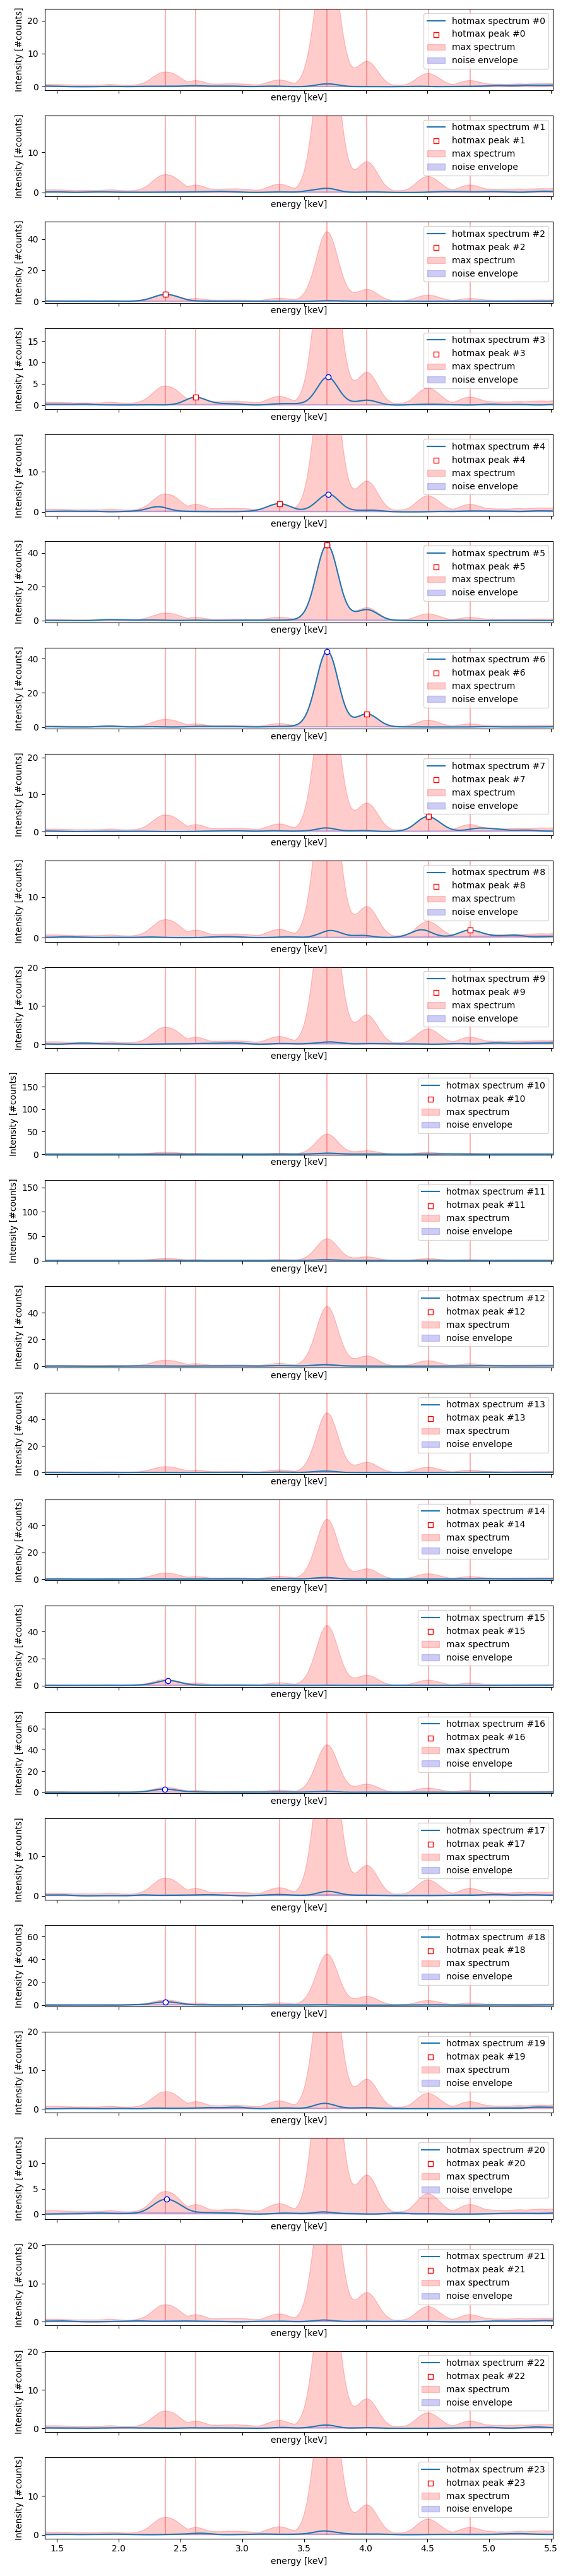

In [ ]:
plot_spectra(hma)

<IPython.core.display.Javascript object>


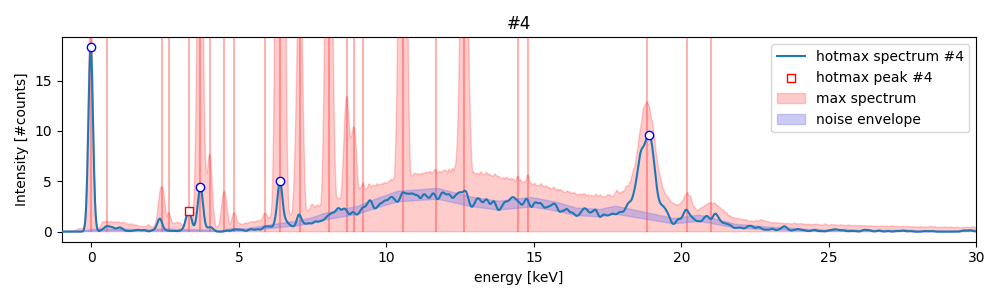

<AxesSubplot:title={'center':'#4'}, xlabel='energy [keV]', ylabel='Intensity [#counts]'>

In [ ]:
hma.plot_spectrum(4)

<IPython.core.display.Javascript object>


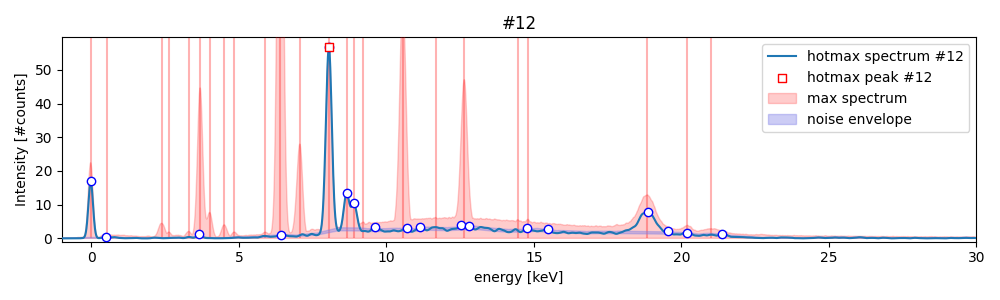

In [ ]:
hma.plot_spectrum(12);

The result is not perfect, but most of the noise peaks do not exceed the noise envelope. 